# Ceased Labours analisys
This notebook tries to reply to this main research questions:
- What is the future trend of the ceased labours
- Derive a profile of the people leaving their jobs
- Predict the study title of people leaving their jobs based on the other features.

For full plotly graphs access the notebook on https://colab.research.google.com/drive/1rqR5S5iogd7ZTog2ibRPdGWladOALtpZ?usp=sharing

In [1]:
from google.colab import drive
drive.mount('gdrive/')

Mounted at gdrive/


In [2]:
!pip install chart_studio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 64 kB 1.8 MB/s 
  Created wheel for retrying: filename=retrying-1.3.3-py3-none-any.whl size=11447 sha256=677c0ed3b46574ce5625488a917a06f25864ee9d29de99f8d6fd8e90024873e1
  Stored in directory: /root/.cache/pip/wheels/f9/8d/8d/f6af3f7f9eea3553bc2fe6d53e4b287dad18b06a861ac56ddf
Successfully built retrying


In [3]:
from importlib import reload
from datetime import datetime
import re
import sys

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf

from plotly.offline import iplot
from chart_studio import tools
from chart_studio import plotly as py
tools.set_credentials_file(username='andrenonali',                                              
                                  api_key='WXzt1WciwazvdQhs6ORT')
import plotly.graph_objs as go

import utils
reload(utils)

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


<module 'utils' from '/content/utils.py'>

In [4]:
ceased_labours = pd.read_csv("gdrive/MyDrive/DSFB/ceased_labours.csv")
ceased_labours.head()

,DATA,GENERE,ETA,SETTOREECONOMICODETTAGLIO,TITOLOSTUDIO,CONTRATTO,MODALITALAVORO,PROVINCIAIMPRESA,ITALIANO
0,02/04/2019,M,20,Lavori di meccanica generale,DIPLOMA DI ISTRUZIONE SECONDARIA SUPERIORE CH...,APPRENDISTATO PROFESSIONALIZZANTE O CONTRATTO ...,TEMPO PIENO,BERGAMO,ITALIA
1,08/06/2018,F,28,Fabbricazione di altre apparecchiature elettri...,DIPLOMA DI ISTRUZIONE SECONDARIA SUPERIORE CH...,APPRENDISTATO PROFESSIONALIZZANTE O CONTRATTO ...,TEMPO PIENO,BERGAMO,ITALIA
2,02/02/2016,F,20,Fabbricazione di altre apparecchiature elettri...,DIPLOMA DI ISTRUZIONE SECONDARIA SUPERIORE CH...,APPRENDISTATO PROFESSIONALIZZANTE O CONTRATTO ...,TEMPO PIENO,BERGAMO,ITALIA
3,12/01/2015,M,59,"Gestioni di funicolari, ski-lift e seggiovie s...",LICENZA MEDIA,LAVORO A TEMPO DETERMINATO,TEMPO PIENO,BERGAMO,ITALIA
4,09/08/2017,M,61,"Gestioni di funicolari, ski-lift e seggiovie s...",LICENZA MEDIA,LAVORO A TEMPO DETERMINATO,TEMPO PIENO,BERGAMO,ITALIA


In [5]:
ceased_labours.dtypes

DATA                         object
GENERE                       object
ETA                           int64
SETTOREECONOMICODETTAGLIO    object
TITOLOSTUDIO                 object
CONTRATTO                    object
MODALITALAVORO               object
PROVINCIAIMPRESA             object
ITALIANO                     object
dtype: object

### Rename column 'ITALIANO' to 'NAZIONALITA'

In [6]:
ceased_labours.rename({'ITALIANO': 'NAZIONALITA'}, axis=1, inplace=True)

In [7]:
ceased_labours.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1314369 entries, 0 to 1314368
Data columns (total 9 columns):
 #   Column                     Non-Null Count    Dtype 
---  ------                     --------------    ----- 
 0   DATA                       1314369 non-null  object
 1   GENERE                     1314369 non-null  object
 2   ETA                        1314369 non-null  int64 
 3   SETTOREECONOMICODETTAGLIO  1314043 non-null  object
 4   TITOLOSTUDIO               1314203 non-null  object
 5   CONTRATTO                  1314368 non-null  object
 6   MODALITALAVORO             1314368 non-null  object
 7   PROVINCIAIMPRESA           1314368 non-null  object
 8   NAZIONALITA                1314368 non-null  object
dtypes: int64(1), object(8)
memory usage: 90.3+ MB


# Data cleaning

## Null inspection

In [8]:
utils.missing_values_table(ceased_labours)

Your selected dataframe has 9 columns.
There are 6 columns that have missing values.


,Missing Values,% of Total Values
SETTOREECONOMICODETTAGLIO,326,0.0
TITOLOSTUDIO,166,0.0
CONTRATTO,1,0.0
MODALITALAVORO,1,0.0
PROVINCIAIMPRESA,1,0.0
NAZIONALITA,1,0.0


In [9]:
utils.get_percent_missing(ceased_labours, columns=['SETTOREECONOMICODETTAGLIO', 'TITOLOSTUDIO'])

SETTOREECONOMICODETTAGLIO    0.024803
TITOLOSTUDIO                 0.012630
dtype: float64

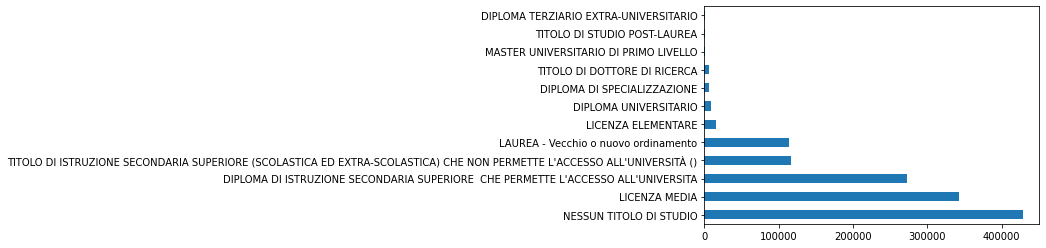

In [10]:
ceased_labours.TITOLOSTUDIO.value_counts().plot(kind='barh')

For the column TITOLOSTUDIO we can see the null values are really a minmal part of the dataset, so we can delete them quite safely wihthout risking to lose information, or risking to add a bias by filling them.
Maybe we can add an 'unkwon' field but the impact is still low

The same goes for the column SETTOREECONOMICODETTAGLIO which has also a huge amount of categorical unique values

In [11]:
ceased_labours.dropna(inplace=True)
utils.missing_values_table(ceased_labours)

Your selected dataframe has 9 columns.
There are 0 columns that have missing values.


,Missing Values,% of Total Values


## Duplicated data inspection

In [12]:
ceased_labours.duplicated().sum()

20639

Do we want to drop duplicates ?
In this case, duplicated columns data means that two or more people ceased their labours in the same circumstances. By dropping the duplicates we remove this information, which could be relevant.
The number of duplicated values is big. So we can also think about sampling the data to have a smaller set of duplicate values, but the issue is the same of dropping them.

# Data Exploration & Statistics

## Continuous data
The only column containing continuous data is 'ETA'

In [13]:
ceased_labours.ETA.describe()

count    1.313877e+06
mean     3.808446e+01
std      1.259736e+01
min      0.000000e+00
25%      2.800000e+01
50%      3.700000e+01
75%      4.700000e+01
max      6.210000e+02
Name: ETA, dtype: float64

We have a max value of 621. Clearly it's not human, so we can inspect the column, and probably delete this outlier.

In [14]:
max_age_idx = ceased_labours.ETA.idxmax()
ceased_labours.loc[max_age_idx]

DATA                                                   12/11/2600
GENERE                                                          M
ETA                                                           621
SETTOREECONOMICODETTAGLIO    Fabbricazione di imballaggi in legno
TITOLOSTUDIO                              NESSUN TITOLO DI STUDIO
CONTRATTO                              LAVORO A TEMPO DETERMINATO
MODALITALAVORO                                        TEMPO PIENO
PROVINCIAIMPRESA                                          MANTOVA
NAZIONALITA                                                 GHANA
Name: 1269413, dtype: object

It could be a typo, but we can't guess with certainty the age of the person, that could be a left-to-right combination of the 621, like 62, 21, 61.
For this reason we can drop this record.

In [15]:
ceased_labours.drop(max_age_idx, inplace=True)

We can apply the same reasoning for the minimun value, which is zero.
However, in this case we can also remove the values v such that v < 16, since 16 is the minimum legal age to activate a job.

In [16]:
ceased_labours = ceased_labours[ceased_labours['ETA'] > 16]

In [17]:
ceased_labours.describe()

,ETA
count,1.310735e+06
mean,3.814891e+01
std,1.252961e+01
min,1.700000e+01
25%,2.800000e+01
50%,3.700000e+01
75%,4.700000e+01
max,1.100000e+02


In [18]:
ceased_labours.ETA.mode()

0    26
dtype: int64

In [19]:
ceased_labours.ETA.median()

37.0

In [20]:
_range = ceased_labours.ETA.max() - ceased_labours.ETA.min()
_range

93

The mode value is 26, which is nearest to the lower bound than the right one, considering the range of 58. According to the mean and the median, we may think that there is a right skewed probability distribution.


### Data distribution for 'ETA': plotting
We can inspect the distribution of the 'ETA' column. By knowing the distribution we can decide what strategy to apply. For example if it is a **normal distribution** we can use the z-score.

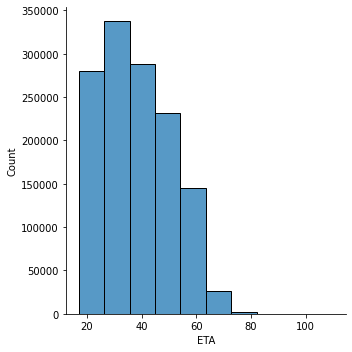

In [21]:
sns.displot(x=ceased_labours.ETA, bins=10)

The distribution is skewed right. 
Possible outliers may be on the right hand of the distribiution. We can try to plot them with a box plot.

### Outliers

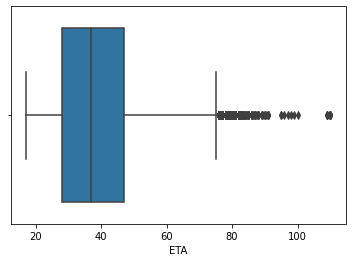

In [22]:
sns.boxplot(x=ceased_labours.ETA)

The box plot confirms the right skewness of the data.
We can try to programmatically remove the values on the right 

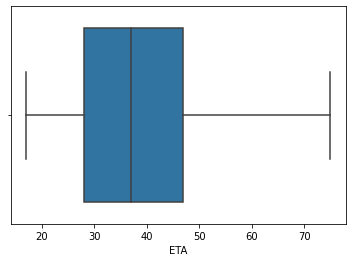

In [23]:
right_whisker = utils.get_right_whisker(ceased_labours, 'ETA')

ceased_labours = ceased_labours[ceased_labours['ETA'] < right_whisker]  

sns.boxplot(x=ceased_labours.ETA)

## Categorical data 

In [24]:
ceased_labours.nunique()

DATA                         2188
GENERE                          2
ETA                            59
SETTOREECONOMICODETTAGLIO    1190
TITOLOSTUDIO                   12
CONTRATTO                      53
MODALITALAVORO                  5
PROVINCIAIMPRESA               12
NAZIONALITA                   185
dtype: int64

I can try to plot the frequency table of some of them

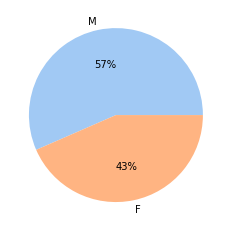

In [25]:
utils.plot_frequency_pie(ceased_labours, 'GENERE')

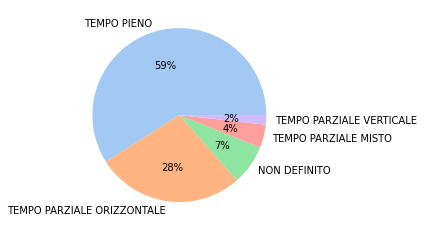

In [26]:
utils.plot_frequency_pie(ceased_labours, 'MODALITALAVORO')

Most of the ceased labours seems to come from full time jobs.

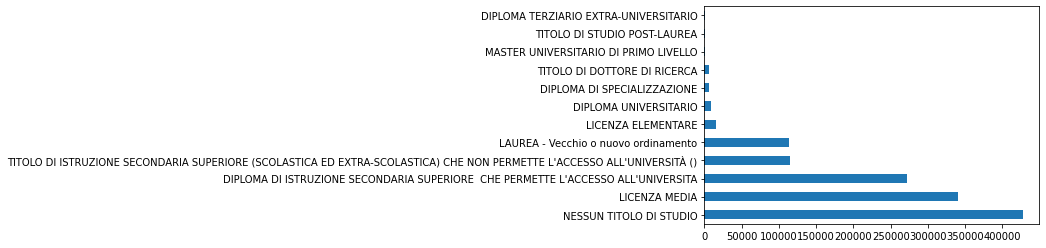

In [27]:
utils.plot_frequency_table(ceased_labours, 'TITOLOSTUDIO')

It seems that educated people have less proability to be fired. However there is also a good amount of people with only elementary school that have low ceased labor probability.

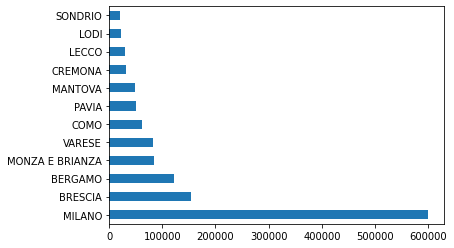

In [28]:
utils.plot_frequency_table(ceased_labours, 'PROVINCIAIMPRESA')

We can guess that in Milan people tend to change job more frequently, or that Milan has a working poputlation that is higher than other cities.
To verify this guess we can integrate this analysy with other data, for example from istat.

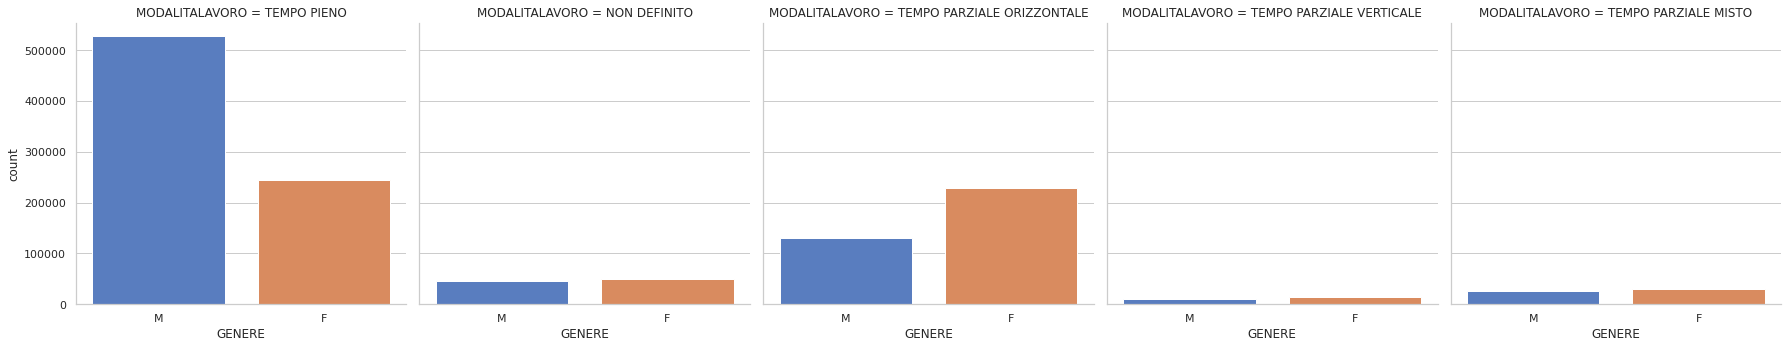

In [29]:
sns.set(style="whitegrid")
g = sns.catplot(x="GENERE", col="MODALITALAVORO", kind="count", data=ceased_labours, palette="muted")

Women that works part time, especially horizontally, seems to have more probability to be fired than men. But when working full time they are less subject to firing.

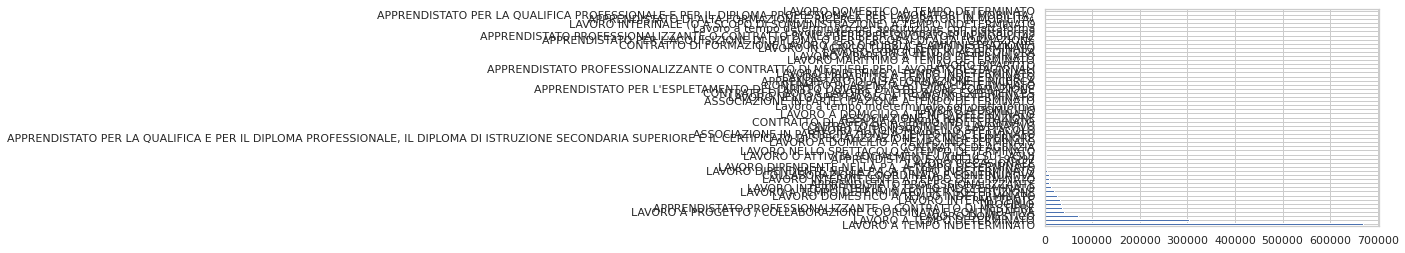

In [30]:
utils.plot_frequency_table(ceased_labours, 'CONTRATTO')

There are too many values that are not relevant. 
We can try to remove them

In [31]:
# set a threshold as count of values of 1%
lower_threshold = len(ceased_labours) * 0.01
ceased_labours = ceased_labours.groupby('CONTRATTO').filter(lambda x : len(x)> lower_threshold)

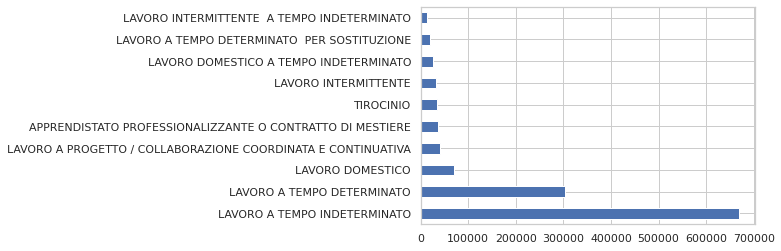

In [32]:
utils.plot_frequency_table(ceased_labours, 'CONTRATTO')

# Transformations

In [33]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

In [34]:
ceased_labours.head()

,DATA,GENERE,ETA,SETTOREECONOMICODETTAGLIO,TITOLOSTUDIO,CONTRATTO,MODALITALAVORO,PROVINCIAIMPRESA,NAZIONALITA
0,02/04/2019,M,20,Lavori di meccanica generale,DIPLOMA DI ISTRUZIONE SECONDARIA SUPERIORE CH...,APPRENDISTATO PROFESSIONALIZZANTE O CONTRATTO ...,TEMPO PIENO,BERGAMO,ITALIA
1,08/06/2018,F,28,Fabbricazione di altre apparecchiature elettri...,DIPLOMA DI ISTRUZIONE SECONDARIA SUPERIORE CH...,APPRENDISTATO PROFESSIONALIZZANTE O CONTRATTO ...,TEMPO PIENO,BERGAMO,ITALIA
2,02/02/2016,F,20,Fabbricazione di altre apparecchiature elettri...,DIPLOMA DI ISTRUZIONE SECONDARIA SUPERIORE CH...,APPRENDISTATO PROFESSIONALIZZANTE O CONTRATTO ...,TEMPO PIENO,BERGAMO,ITALIA
3,12/01/2015,M,59,"Gestioni di funicolari, ski-lift e seggiovie s...",LICENZA MEDIA,LAVORO A TEMPO DETERMINATO,TEMPO PIENO,BERGAMO,ITALIA
4,09/08/2017,M,61,"Gestioni di funicolari, ski-lift e seggiovie s...",LICENZA MEDIA,LAVORO A TEMPO DETERMINATO,TEMPO PIENO,BERGAMO,ITALIA


In [35]:
ceased_transformed = pd.DataFrame()

### GENERE -> dummies

In [36]:
one_hot_encoder = OneHotEncoder()

In [37]:
df_col = ceased_labours['GENERE'].values.reshape(-1,1)
df_col

array([['M'],
       ['F'],
       ['F'],
       ...,
       ['M'],
       ['F'],
       ['F']], dtype=object)

In [38]:
X = one_hot_encoder.fit_transform(df_col).toarray()

In [39]:
ceased_transformed = pd.concat(
    [ceased_transformed, pd.DataFrame(X, columns=['GENERE_F', 'GENERE_M'])],
    axis=1
)
ceased_transformed.head()

,GENERE_F,GENERE_M
0,0.0,1.0
1,1.0,0.0
2,1.0,0.0
3,0.0,1.0
4,0.0,1.0


### TITOLO STUDIO -> custom transformation
following this ordinal rules [ISTAT document](https://www.istat.it/it/files/2011/01/Classificazione-titoli-studio-28_ott_2005-nota_metodologica.pdf)

In [40]:
ceased_labours.TITOLOSTUDIO.unique()

array(["DIPLOMA DI ISTRUZIONE SECONDARIA SUPERIORE  CHE PERMETTE L'ACCESSO ALL'UNIVERSITA",
       'LICENZA MEDIA',
       "TITOLO DI ISTRUZIONE SECONDARIA SUPERIORE (SCOLASTICA ED EXTRA-SCOLASTICA) CHE NON PERMETTE L'ACCESSO ALL'UNIVERSITÀ ()",
       'LICENZA ELEMENTARE', 'NESSUN TITOLO DI STUDIO',
       'LAUREA - Vecchio o nuovo ordinamento', 'DIPLOMA UNIVERSITARIO',
       'DIPLOMA DI SPECIALIZZAZIONE', 'TITOLO DI STUDIO POST-LAUREA',
       'TITOLO DI DOTTORE DI RICERCA',
       'MASTER UNIVERSITARIO DI PRIMO LIVELLO',
       'DIPLOMA TERZIARIO EXTRA-UNIVERSITARIO'], dtype=object)

In [41]:
mapper = {
    'NESSUN TITOLO DI STUDIO': 0,
    'LICENZA ELEMENTARE': 1,
    'LICENZA MEDIA': 2,
    'TITOLO DI ISTRUZIONE SECONDARIA SUPERIORE (SCOLASTICA ED EXTRA-SCOLASTICA) CHE NON PERMETTE L\'ACCESSO ALL\'UNIVERSITÀ ()': 3,
    'DIPLOMA DI ISTRUZIONE SECONDARIA SUPERIORE  CHE PERMETTE L\'ACCESSO ALL\'UNIVERSITA': 4,
    'DIPLOMA TERZIARIO EXTRA-UNIVERSITARIO': 5,
    'DIPLOMA UNIVERSITARIO': 6,
    'LAUREA - Vecchio o nuovo ordinamento': 7,
    'MASTER UNIVERSITARIO DI PRIMO LIVELLO': 8,
    'DIPLOMA DI SPECIALIZZAZIONE': 9,
    'TITOLO DI DOTTORE DI RICERCA': 10,
    'TITOLO DI STUDIO POST-LAUREA': 11
}
ceased_transformed['TITOLOSTUDIO'] = ceased_labours['TITOLOSTUDIO'].replace(mapper)
ceased_transformed.head()

,GENERE_F,GENERE_M,TITOLOSTUDIO
0,0.0,1.0,4.0
1,1.0,0.0,4.0
2,1.0,0.0,4.0
3,0.0,1.0,2.0
4,0.0,1.0,2.0


In [42]:
ceased_transformed.TITOLOSTUDIO.unique()

array([ 4.,  2.,  3.,  1.,  0., nan,  7.,  6.,  9., 11., 10.,  8.,  5.])

In [43]:
utils.missing_values_table(ceased_transformed)

Your selected dataframe has 3 columns.
There are 1 columns that have missing values.


,Missing Values,% of Total Values
TITOLOSTUDIO,64019,5.1


In [44]:
ceased_transformed.fillna(0, inplace=True)

In [45]:
utils.missing_values_table(ceased_transformed)

Your selected dataframe has 3 columns.
There are 0 columns that have missing values.


,Missing Values,% of Total Values


### [MODALITÀ LAVORO, PROVINCIAIMPRESA, NAZIONALITA, CONTRATTO] -> LabelEncoder

In [46]:
label_encoder = LabelEncoder()

def label_encoder_transform(feature: pd.core.series.Series):
    return label_encoder.fit_transform(feature)

In [47]:
ceased_transformed['MODALITALAVORO']   = label_encoder_transform(ceased_labours.MODALITALAVORO)
ceased_transformed['PROVINCIAIMPRESA'] = label_encoder_transform(ceased_labours.PROVINCIAIMPRESA)
ceased_transformed['NAZIONALITA']      = label_encoder_transform(ceased_labours.NAZIONALITA)
ceased_transformed['CONTRATTO']        = label_encoder_transform(ceased_labours.CONTRATTO)


In [48]:
ceased_transformed.head()

,GENERE_F,GENERE_M,TITOLOSTUDIO,MODALITALAVORO,PROVINCIAIMPRESA,NAZIONALITA,CONTRATTO
0,0.0,1.0,4.0,4,0,86,0
1,1.0,0.0,4.0,4,0,86,0
2,1.0,0.0,4.0,4,0,86,0
3,0.0,1.0,2.0,4,0,86,2
4,0.0,1.0,2.0,4,0,86,2


In [49]:
ceased_transformed.PROVINCIAIMPRESA.unique()

array([ 0,  4,  1,  2,  5,  6,  3,  9,  7, 11, 10,  8])

Add the columns that doesn't need transformations

In [50]:
ceased_transformed['ETA'] = ceased_labours['ETA']

In [51]:
ceased_transformed.head(1)

,GENERE_F,GENERE_M,TITOLOSTUDIO,MODALITALAVORO,PROVINCIAIMPRESA,NAZIONALITA,CONTRATTO,ETA
0,0.0,1.0,4.0,4,0,86,0,20.0


# Time Analysis

In [52]:
from fbprophet import Prophet

In [53]:
timed_labours = ceased_labours.copy()

##### Convert 'DATA' column into datetime field

Control the format

In [54]:
r = re.compile(r'[0-9][0-9]\/[0-9][0-9]\/[0-9][0-9][0-9][0-9]')
regmatch = np.vectorize(lambda x: bool(r.match(x)))

matches = regmatch(timed_labours.DATA.values)
if np.count_nonzero(matches) == len(timed_labours.DATA):
    print("All the values in the data columns matches the pattern")
else:
    raise Exception("ERROR: not all the values in the data columns matches the pattern")

All the values in the data columns matches the pattern


Convert the data

In [55]:
timed_labours.DATA= timed_labours.DATA.apply(
    lambda date_str: datetime.strptime(date_str, "%d/%m/%Y")
)

In [56]:
timed_labours.DATA.head()

0   2019-04-02
1   2018-06-08
2   2016-02-02
3   2015-01-12
4   2017-08-09
Name: DATA, dtype: datetime64[ns]

In [57]:
timed_labours.dtypes

DATA                         datetime64[ns]
GENERE                               object
ETA                                   int64
SETTOREECONOMICODETTAGLIO            object
TITOLOSTUDIO                         object
CONTRATTO                            object
MODALITALAVORO                       object
PROVINCIAIMPRESA                     object
NAZIONALITA                          object
dtype: object

Sort by date

In [58]:
utils.sort_by(timed_labours, 'DATA')

Sorted


Create the month and year columns

In [59]:
timed_labours['MONTH'] = timed_labours.DATA.apply(lambda _date: _date.month)

In [60]:
timed_labours['YEAR'] = timed_labours.DATA.apply(lambda _date: _date.year)

Set the DATA columns as the index

In [61]:
timed_labours.set_index('DATA', inplace=True)

Distribution of ceased labours in all years by month

In [62]:
monthly_count = timed_labours.groupby(timed_labours.index.month).count().iloc[:, [0]]
monthly_count.rename(columns={'GENERE': 'COUNT'}, inplace=True)
monthly_count

,COUNT
DATA,
1,146769
2,159548
3,146246
4,136161
5,109101
6,75576
7,77073
8,72766
9,78983


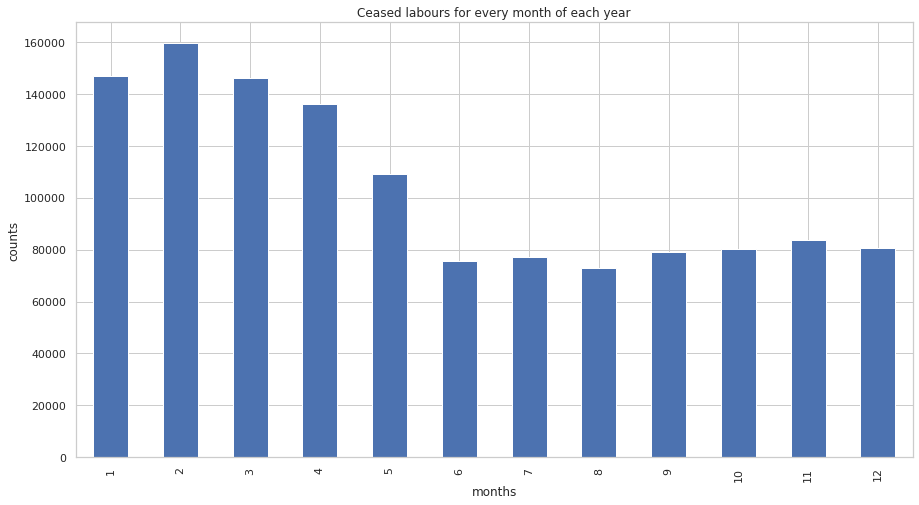

In [63]:
monthly_count.plot(
    title='Ceased labours for every month of each year',
    xlabel='months',
    ylabel='counts',
    kind='bar',
    legend=False,
    figsize=(15, 8)
)

##### Analyze the time series

In [64]:
timed_labours2 = timed_labours[['GENERE']]

In [65]:
timed_labours2 = timed_labours2.resample('M').count()
timed_labours2.rename(columns={'GENERE': 'COUNT'}, inplace=True)
timed_labours2.head()

,COUNT
DATA,
1988-12-31,1
1989-01-31,0
1989-02-28,0
1989-03-31,0
1989-04-30,0


In [66]:
# filter data that are too low
timed_labours2 = timed_labours2[timed_labours2.COUNT > 100]

In [67]:
py.iplot(
    go.Figure(
      data=[go.Scatter(x=timed_labours2.index, y=timed_labours2.COUNT)],
      layout= go.Layout(
          title='Ceased Labours', 
          xaxis=dict(title='Day'), 
          yaxis=dict(title='(Count)'))
    ),
)

Firstly, by interacting with the plot we can see that in the first months of each year there is a peak in ceased labours. 
Moreover in 2008 people started ceasing their job, and until 2012 the most amount of job were ceased, maybe due to the italian economic crisis.

#### Autocorrelation

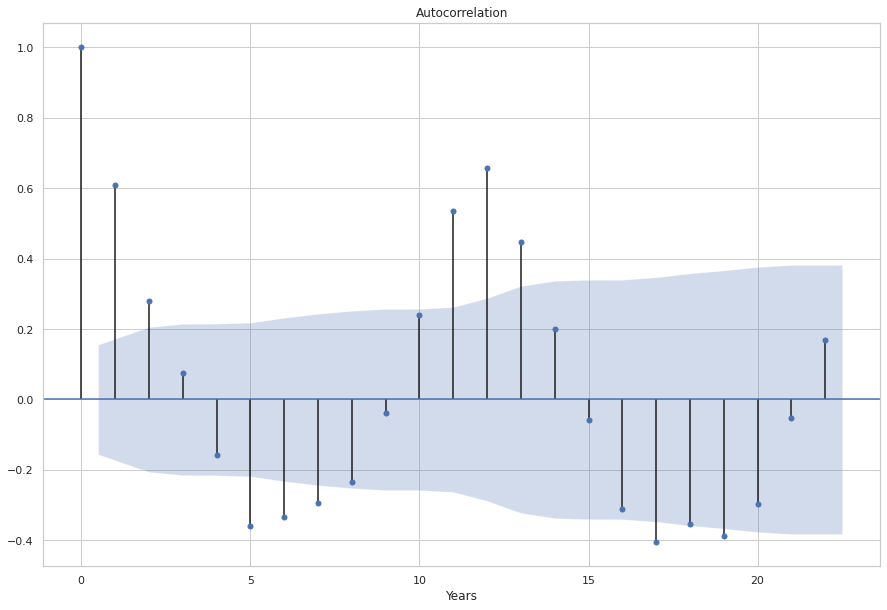

In [68]:
plt.rc('figure', figsize=(15, 10))
plot_acf(timed_labours2)
plt.xlabel('Years')
plt.show()

As we already seen in the time series, there is a little correlation during the first day of the months

## Prophet time series forecasting

Our research question is to forecast the future trend of 2022, to understand if it will be a year in which people are more likely not to quit their job, looking for stability in the period after the covid 19 pandemic.

In [69]:
timed_labours2.columns

Index(['COUNT'], dtype='object')

In [70]:
X, y = utils.create_prophet_features(timed_labours2, label='COUNT')

features_and_target = pd.concat([X, y], axis=1)

print("Shape",features_and_target.shape)
features_and_target.head(10)

Shape (158, 9)


/content/utils.py:127: FutureWarning:

Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.



,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,COUNT
DATA,,,,,,,,,
2001-01-31,0,2,1,1,2001,31,31,5,444
2008-10-31,0,4,4,10,2008,305,31,44,178
2009-01-31,0,5,1,1,2009,31,31,5,8394
2009-02-28,0,5,1,2,2009,59,28,9,7755
2009-03-31,0,1,1,3,2009,90,31,14,6513
2009-04-30,0,3,2,4,2009,120,30,18,4880
2009-05-31,0,6,2,5,2009,151,31,22,3343
2009-06-30,0,1,2,6,2009,181,30,27,3126
2009-07-31,0,4,3,7,2009,212,31,31,3187


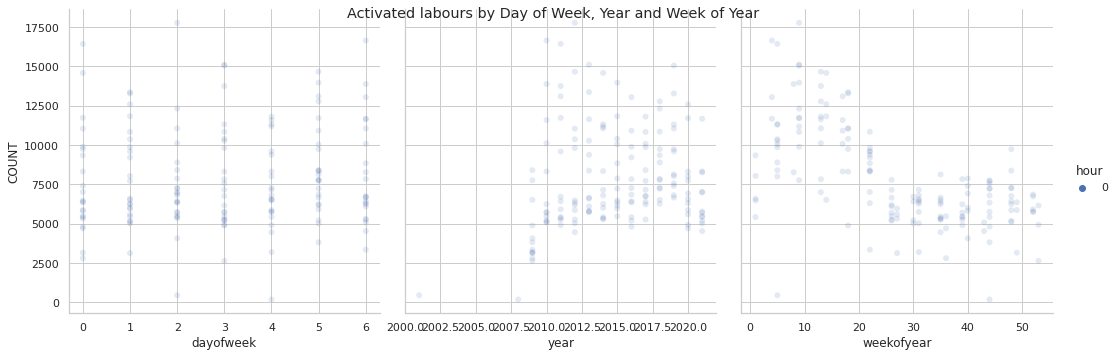

In [71]:
sns.pairplot(
    features_and_target.dropna(),
    hue='hour',
    x_vars=['dayofweek','year','weekofyear'],
    y_vars='COUNT',height=5,
    plot_kws={'alpha':0.15, 'linewidth':0}
)
plt.suptitle('Activated labours by Day of Week, Year and Week of Year')
plt.show()

In [72]:
split_date = '01-Jan-2018'
timed_labours_train = timed_labours2.loc[timed_labours2.index <= split_date].copy()
timed_labours_test = timed_labours2.loc[timed_labours2.index > split_date].copy()

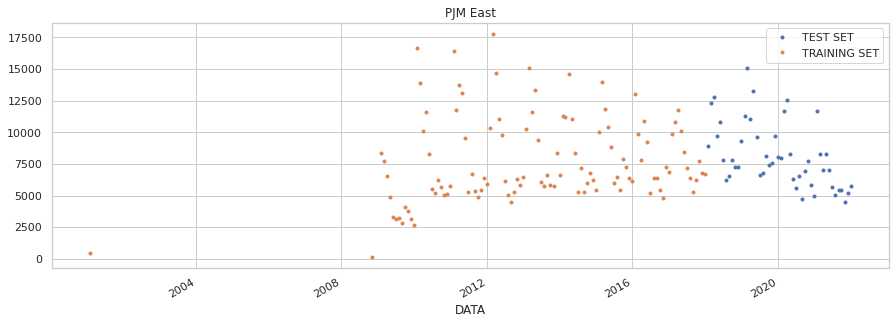

In [73]:
timed_labours_test \
    .rename(columns={'COUNT': 'TEST SET'}) \
    .join(timed_labours_train.rename(columns={'COUNT': 'TRAINING SET'}), how='outer') \
    .plot(figsize=(15,5), title='PJM East', style='.')
plt.show()

In [74]:
timed_labours_train.reset_index().rename(
    columns={'DATA':'ds','COUNT':'y'}
)
timed_labours_train.head(5)

,COUNT
DATA,
2001-01-31,444
2008-10-31,178
2009-01-31,8394
2009-02-28,7755
2009-03-31,6513


In [75]:
model = Prophet()
model.fit(
    timed_labours_train \
      .reset_index() \
      .rename(columns={'DATA':'ds','COUNT':'y'})
)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Predict data for 2022 and 2023

In [76]:
future = list()
for i in range(1, 13):
	date = '2022-%02d' % i
	future.append([date])
for i in range(1, 13):
	date = '2023-%02d' % i
	future.append([date])
future = pd.DataFrame(future)
future.columns = ['ds']
future['ds']= pd.to_datetime(future['ds'])

In [77]:
forecast = model.predict(future)

In [78]:
from fbprophet.plot import plot_plotly, plot_components_plotly

plot_plotly(model, forecast)

In [79]:
plot_components_plotly(model, forecast)

The Prophet model predicted a decrasing trend in ceased labours in the next two years. However as we have seen for 2008 financial crisis, after a difficult economical period, people seem to quit their job or being fired increasingly.

# Profiling

Can we derive a profile of the people leaving their job ?

In [80]:
from sklearn.cluster import KMeans
from sklearn import preprocessing

In [81]:
ceased_transformed.head()

,GENERE_F,GENERE_M,TITOLOSTUDIO,MODALITALAVORO,PROVINCIAIMPRESA,NAZIONALITA,CONTRATTO,ETA
0,0.0,1.0,4.0,4,0,86,0,20.0
1,1.0,0.0,4.0,4,0,86,0,28.0
2,1.0,0.0,4.0,4,0,86,0,20.0
3,0.0,1.0,2.0,4,0,86,2,59.0
4,0.0,1.0,2.0,4,0,86,2,61.0


In [82]:
X = ceased_transformed

y = ceased_transformed['TITOLOSTUDIO']

Feature scaling

In [83]:
cols = X.columns

In [84]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

X = scaler.fit_transform(X)

In [85]:
X = pd.DataFrame(X, columns=[cols])

In [86]:
X.head()

,GENERE_F,GENERE_M,TITOLOSTUDIO,MODALITALAVORO,PROVINCIAIMPRESA,NAZIONALITA,CONTRATTO,ETA
0,0.0,1.0,0.363636,1.0,0.0,0.469945,0.000000,0.051724
1,1.0,0.0,0.363636,1.0,0.0,0.469945,0.000000,0.189655
2,1.0,0.0,0.363636,1.0,0.0,0.469945,0.000000,0.051724
3,0.0,1.0,0.181818,1.0,0.0,0.469945,0.222222,0.724138
4,0.0,1.0,0.181818,1.0,0.0,0.469945,0.222222,0.758621


In [87]:
X.fillna(0, inplace=True)

In [88]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=2, random_state=0) 

kmeans.fit(X)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.



KMeans(n_clusters=2, random_state=0)

Elbow method

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning:

Feature names only support names th

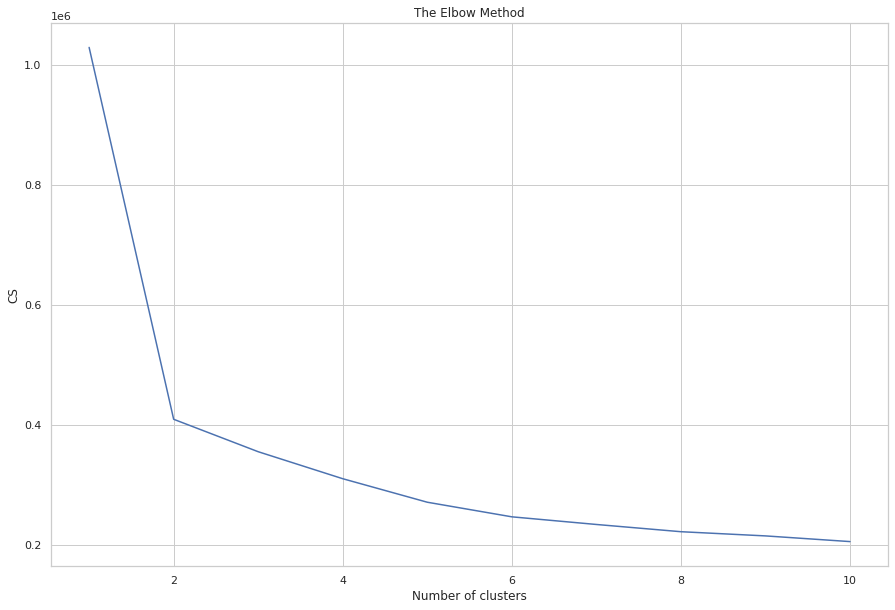

In [89]:
cs = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
    kmeans.fit(X)
    cs.append(kmeans.inertia_)
plt.plot(range(1, 11), cs)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('CS')
plt.show()

In [90]:
from sklearn.cluster import KMeans

kmeans_2 = KMeans(n_clusters=2, random_state=0) 

kmeans_2.fit(X)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.



KMeans(n_clusters=2, random_state=0)

In [91]:
correct_labels = sum(y == kmeans_2.labels_)
print('Accuracy score: {0:0.2f}'. format(correct_labels/float(y.size)))

Accuracy score: 0.21


In [92]:
from sklearn.cluster import KMeans

kmeans_6 = KMeans(n_clusters=6, random_state=0) 

kmeans_6.fit(X)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.



KMeans(n_clusters=6, random_state=0)

In [93]:
correct_labels = sum(y == kmeans_6.labels_)
print('Accuracy score: {0:0.2f}'. format(correct_labels/float(y.size)))

Accuracy score: 0.16


The accuracy score is not satisfactory. Let's try with dbscan

In [94]:
#from sklearn.cluster import DBSCAN
#db = DBSCAN()

In [95]:
# use only 10% of the data
#X = X[::10]
#model=db.fit(X)

# Predictions

### Data Scaling

In [96]:
from sklearn.preprocessing import StandardScaler

In [97]:
ceased_transformed_temp = ceased_transformed.copy()

ceased_scaled = pd.DataFrame(
    StandardScaler().fit_transform(ceased_transformed_temp), 
    columns=ceased_transformed_temp.columns
)

In [98]:
ceased_scaled.head()

,GENERE_F,GENERE_M,TITOLOSTUDIO,MODALITALAVORO,PROVINCIAIMPRESA,NAZIONALITA,CONTRATTO,ETA
0,-0.871267,0.871267,0.787763,0.755624,-1.771809,-0.039477,-2.154051,-1.480271
1,1.147754,-1.147754,0.787763,0.755624,-1.771809,-0.039477,-2.154051,-0.833869
2,1.147754,-1.147754,0.787763,0.755624,-1.771809,-0.039477,-2.154051,-1.480271
3,-0.871267,0.871267,-0.105136,0.755624,-1.771809,-0.039477,-0.969327,1.670941
4,-0.871267,0.871267,-0.105136,0.755624,-1.771809,-0.039477,-0.969327,1.832542


### Correlation

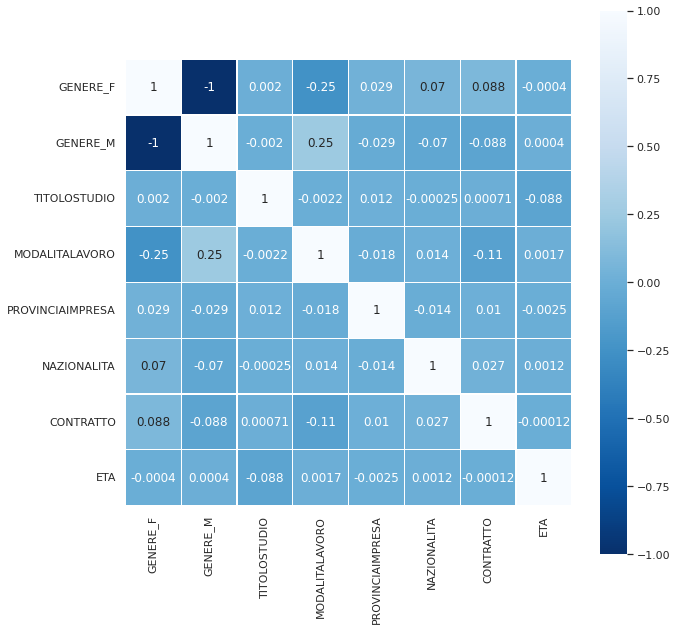

In [99]:
fig, ax = plt.subplots(figsize=(10,10)) 
sns.heatmap(
    ceased_scaled.corr(), 
    square=True,
    linewidths=0.2,
    cmap='Blues_r',
    annot=True
)

As seen in our lessons, without a decent correlation linear regression will fail. We can try to predicit study title using a polynomial regression

## Polynomial regression

### Prepare data for predictions

In [153]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, mean_squared_error
import xgboost as xgb
from sklearn.preprocessing import PolynomialFeatures

In [154]:
ceased_scaled.fillna(0, inplace=True)

In [155]:
X, y = ceased_scaled[['MODALITALAVORO']], ceased_scaled['CONTRATTO']

In [156]:
polynomial_features= PolynomialFeatures(degree=30)
xp = polynomial_features.fit_transform(X)
xp.shape

(1246821, 31)

In [157]:
import statsmodels.api as sm
from sklearn.metrics import r2_score

In [158]:
model = sm.OLS(y, xp).fit()

In [159]:
ypred = model.predict(xp)

In [161]:
float(r2_score(y, ypred))

0.02492952664578152

The polynomial regression does not give satisfactory results. 

## XGBoost regression

In [162]:
import xgboost as xgb
from xgboost import XGBClassifier

In [163]:
xgb_ceased_transformed = ceased_transformed.loc[:, ceased_transformed.columns != 'CONTRATTO']
xgb_ceased_transformed['CONTRATTO']= ceased_transformed['CONTRATTO']

In [164]:
xgb_ceased_transformed.head()

,GENERE_F,GENERE_M,TITOLOSTUDIO,MODALITALAVORO,PROVINCIAIMPRESA,NAZIONALITA,ETA,CONTRATTO
0,0.0,1.0,4.0,4,0,86,20.0,0
1,1.0,0.0,4.0,4,0,86,28.0,0
2,1.0,0.0,4.0,4,0,86,20.0,0
3,0.0,1.0,2.0,4,0,86,59.0,2
4,0.0,1.0,2.0,4,0,86,61.0,2


In [165]:
#Prepare the dataset for prediction
X, y = xgb_ceased_transformed.iloc[:,:-1], xgb_ceased_transformed.iloc[:,-1]

In [166]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [167]:
data_dmatrix = xgb.DMatrix(data=X,label=y)

In [168]:
xg_reg = xgb.XGBRegressor(
    objective='reg:squarederror', 
    colsample_bytree=0.3, 
    learning_rate=0.1,
    max_depth=5,
    alpha=10,
    n_estimators=10
)

In [169]:
xg_reg.fit(X_train, y_train)

XGBRegressor(alpha=10, colsample_bytree=0.3, max_depth=5, n_estimators=10,
             objective='reg:squarederror')

In [170]:
preds = xg_reg.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, preds))
float(rmse)

2.002138741787791

In [171]:
xgb_ceased_transformed.describe()['CONTRATTO']

count    1.246821e+06
mean     3.636377e+00
std      1.688158e+00
min      0.000000e+00
25%      2.000000e+00
50%      4.000000e+00
75%      4.000000e+00
max      9.000000e+00
Name: CONTRATTO, dtype: float64

RMSE is ~2 per 3 as mean value and 9 as max